# Analysis of Hotnet2 Data for GCN

In [164]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn

import sys, os
sys.path.append(os.path.abspath('../GCN'))
from my_gcn import MYGCN

from sklearn.metrics import roc_curve, roc_auc_score, jaccard_similarity_score, accuracy_score
from sklearn.manifold import TSNE

# disable scientific notation in pd and np
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

## Load Model, Data and Heat Scores

In [198]:
heat = pd.read_csv('../data/cancer/hotnet2/heats/pan12.gene2freq.txt', sep=' ', header=None, names=['heat'])
model_dir = '../data/GCN/training/2018_02_14_17_14_55/'
data_file = '../data/cancer/hotnet_iref_heat_input_unbalanced.h5'
CLASSIFICATION_THRESHOLD = .79

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [199]:
# load predictions
predictions = pd.DataFrame.from_csv(model_dir + '/predictions.tsv', sep='\t', header=0)
features_df = pd.DataFrame(features, index=node_names[:, 0])
features_df['neighbors'] = network.sum(axis=0)
pred_with_feat = features_df.join(predictions, how='inner')

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID', 'Name'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0])
labels_df['train_pos'] = y_train[:, 0]
labels_df['test_pos'] = y_test[:, 0]
labels_df['label'] = np.logical_or(train_mask.astype(int), test_mask.astype(int))
labels_df['negative'] = labels_df.label & ~labels_df.positive
labels_df['neighbors'] = network.sum(axis=0)
labels_with_pred = labels_df.join(predictions)

# look at genes that were predicted but were not labeled
pos_predicted = labels_with_pred[labels_with_pred.Prob_pos > CLASSIFICATION_THRESHOLD]
pos_pred_no_label = pos_predicted[pos_predicted.label == 0]

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_predicted.sort_values(by='Prob_pos', ascending=False).to_csv(model_dir + '/positive_prediction.txt', sep='\t')
pos_pred_no_label.sort_values(by='Prob_pos', ascending=False).head(20)

Predicted 848 genes of 12129 total to be involved in infection


,positive,train_pos,test_pos,label,negative,neighbors,Name,Prob_pos
HDAC1,0,0,0,False,False,352.000,HDAC1,1.000
SMARCA2,0,0,0,False,False,72.000,SMARCA2,1.000
MYC,0,0,0,False,False,271.000,MYC,1.000
CCND1,0,0,0,False,False,67.000,CCND1,1.000
HDAC2,0,0,0,False,False,213.000,HDAC2,1.000
HDAC3,0,0,0,False,False,148.000,HDAC3,1.000
E2F1,0,0,0,False,False,89.000,E2F1,1.000
CHD4,0,0,0,False,False,48.000,CHD4,1.000
HIST1H3F,0,0,0,False,False,133.000,HIST1H3F,1.000
TP73,0,0,0,False,False,85.000,TP73,1.000


In [200]:
labels_with_pred[labels_with_pred.label == False].sort_values(by='Prob_pos', ascending=True).head(20)

,positive,train_pos,test_pos,label,negative,neighbors,Name,Prob_pos
PSMC4,0,0,0,False,False,168.000,PSMC4,0.000
POLR2C,0,0,0,False,False,153.000,POLR2C,0.000
EIF4E,0,0,0,False,False,195.000,EIF4E,0.000
MDFI,0,0,0,False,False,165.000,MDFI,0.000
EIF6,0,0,0,False,False,224.000,EIF6,0.000
OAT,0,0,0,False,False,144.000,OAT,0.000
TRAF6,0,0,0,False,False,448.000,TRAF6,0.000
MRPL2,0,0,0,False,False,95.000,MRPL2,0.000
RDH8,0,0,0,False,False,114.000,RDH8,0.000
EIF4A1,0,0,0,False,False,172.000,EIF4A1,0.000


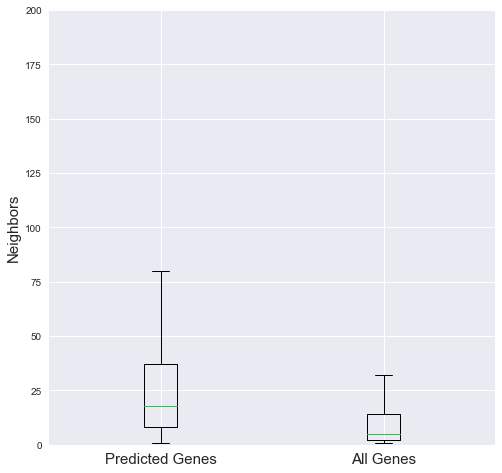

In [201]:
fig = plt.figure(figsize=(8, 8))
x = plt.boxplot([pos_predicted.neighbors,
                 labels_with_pred[labels_with_pred.Prob_pos <= CLASSIFICATION_THRESHOLD].neighbors])
plt.gca().set_ylim([0, 200])
plt.gca().set_xticklabels(['Predicted Genes', 'All Genes'], size=15)
plt.ylabel('Neighbors', size=15)

Optimal classification threshold: 0.7551020408163265


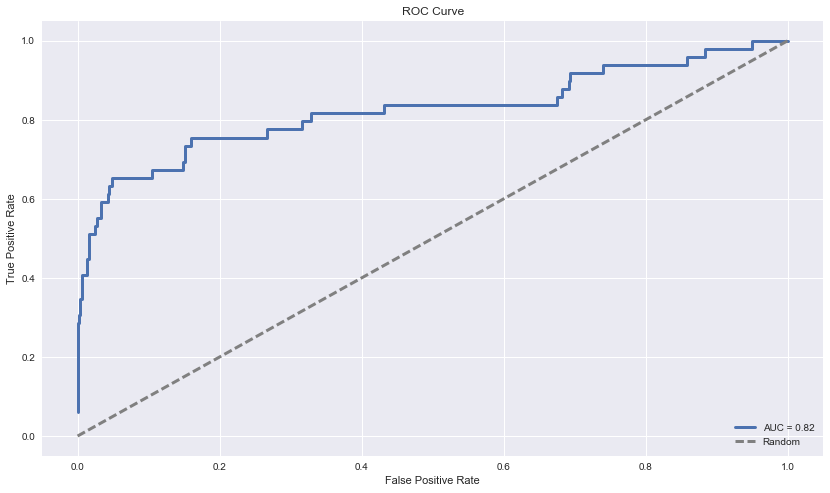

In [204]:

fpr, tpr, thresholds = roc_curve(y_test[test_mask == 1], predictions[test_mask == 1].Prob_pos)
roc_auc = roc_auc_score(y_test[test_mask == 1], predictions[test_mask == 1].Prob_pos)

# compute closest point to upper left
distances = np.sqrt(np.sum((np.array([0, 1]) - np.array([fpr, tpr]).T)**2, axis=1))
idx = np.argmin(distances)
best_threshold = tpr[idx]
print ("Optimal classification threshold: {}".format(best_threshold))
pos_predicted = labels_with_pred[labels_with_pred.Prob_pos > best_threshold]

# plot ROC curve
fig = plt.figure(figsize=(14, 8))
plt.plot(fpr, tpr, lw=3, label='AUC = {0:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
fig.savefig(os.path.join(model_dir, 'roc_curve.png'))
#acc = accuracy_score(y_true=y, y_pred=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD)
#print ("ACCURACY: {}".format(acc))

## Overlap With Hotnet2 Results

In [205]:
# get the hotnet2 predicted subnetworks by reading the data from csv
res_dir = '../data/cancer/hotnet2/hotnet2_results/'
gene_lists = []
net_names = []
for f in os.listdir(res_dir):
    if f.endswith('.csv'):
        name = f.split('.')[0].strip()
        df = pd.read_csv(os.path.join(res_dir, f), sep='\t')
        net_names.append(name)
        genes = set(list(df.gene1) + list(df.gene2))
        gene_lists.append(list(genes))

# the set of all genes (union)
gene_sets = set.union(*[set(l) for l in gene_lists])
print ("Total number of genes: {}".format(len(gene_sets)))

# Look how many genes overlap
avg_percent = 0
for net_idx in range(len(gene_lists)):
    genes = gene_lists[net_idx]
    intersect = pos_predicted[pos_predicted.index.isin(genes)]
    percent = (intersect.shape[0] / float(len(genes))) * 100.
    avg_percent += percent
    print ("[{}] Overlap: {}/{} ({:.1f}%) genes".format(net_names[net_idx],
                                                                     intersect.shape[0],
                                                                     len(genes),
                                                                     percent))
print ('--------------------------')
print ("Average Overlap: {:.2f}%".format(avg_percent / float(len(gene_lists))))

hotnet_genes = gene_sets
gcn_genes = set(pos_predicted.index)
jaccard_idx = len(gcn_genes.intersection(hotnet_genes)) / float(len(gcn_genes.union(hotnet_genes)))
print ("Overall Jaccard Index: {}".format(jaccard_idx))

Total number of genes: 114
[erbb_p53_net] Overlap: 17/52 (32.7%) genes
[notch_p53_net] Overlap: 22/62 (35.5%) genes
[ascom_pi3k_net] Overlap: 11/18 (61.1%) genes
[cohesin_pi3k] Overlap: 8/19 (42.1%) genes
[ascom_p53_net] Overlap: 19/51 (37.3%) genes
[ascom_condensin_net] Overlap: 6/12 (50.0%) genes
[ascom_keap1_net] Overlap: 7/11 (63.6%) genes
[boc_keap1_net] Overlap: 3/7 (42.9%) genes
[cohesin_notch_net] Overlap: 10/24 (41.7%) genes
[cohesin_swisnf_net] Overlap: 7/13 (53.8%) genes
[erbb_keap1_net] Overlap: 5/12 (41.7%) genes
--------------------------
Average Overlap: 45.67%
Overall Jaccard Index: 0.04943357363542739


## Distribution of Node Degree in Predicted vs. Other Genes

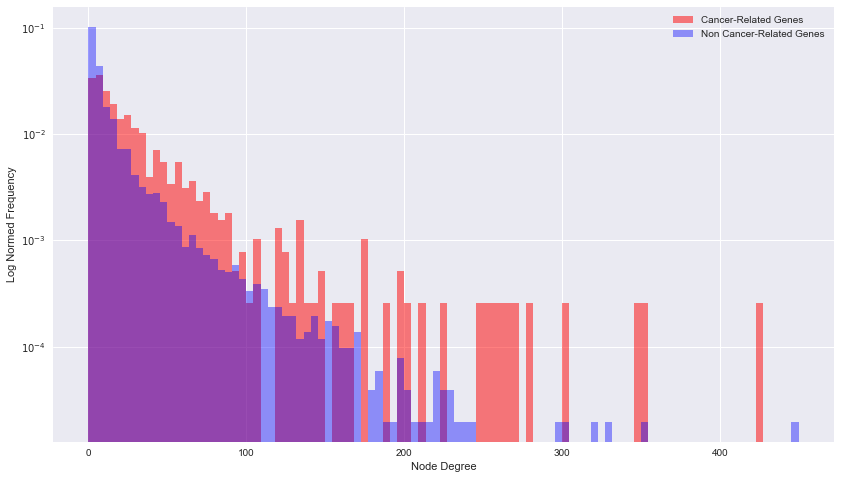

In [206]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(0, 450, 100)
x = plt.hist(pred_with_feat[pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD].neighbors,
         color='red', alpha=.5, normed=True, bins=bins, label='Cancer-Related Genes')
x = plt.hist(pred_with_feat[pred_with_feat.Prob_pos < CLASSIFICATION_THRESHOLD].neighbors,
         color='blue', alpha=.4, normed=True, bins=bins, label='Non Cancer-Related Genes')
plt.yscale('log', nonposy='clip')
plt.xlabel('Node Degree')
plt.ylabel('Log Normed Frequency')
plt.legend()

## Important Nodes

In [197]:
df = pred_with_feat.join(heat)
df.loc[:, 'in_hn_subnets'] = 0
df.loc[df.index.isin(gene_sets), 'in_hn_subnets'] = 1
df.fillna(0, inplace=True)
df.sort_values(by='heat', ascending=False).head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,neighbors,Name,Prob_pos,heat,in_hn_subnets
TP53,10.420,10.500,10.950,10.630,10.190,10.010,10.940,10.180,10.310,11.020,11.150,11.560,427.000,TP53,1.000,0.415,1
PIK3CA,8.840,9.260,7.600,8.440,9.410,8.930,9.460,8.700,9.660,8.780,7.530,7.880,45.000,PIK3CA,1.000,0.194,1
PTEN,10.530,11.000,10.200,9.840,10.780,11.090,11.880,10.660,10.520,10.540,10.000,10.470,43.000,PTEN,1.000,0.105,1
CCND1,11.790,12.830,12.030,10.430,12.280,13.630,5.180,12.420,11.760,11.340,12.010,11.820,67.000,CCND1,1.000,0.099,1
MYC,10.650,10.670,12.450,9.730,12.070,10.610,11.450,10.260,11.440,11.590,12.790,9.580,271.000,MYC,1.000,0.091,0
EGFR,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,303.000,EGFR,1.000,0.084,1
CDKN2A,6.770,6.760,6.720,6.500,7.480,5.670,4.800,6.790,7.360,10.890,7.170,8.330,75.000,CDKN2A,1.000,0.083,1
KRAS,10.230,10.330,9.840,9.660,10.340,10.000,10.670,10.500,10.530,10.340,9.520,9.680,23.000,KRAS,1.000,0.083,1
APC,9.230,9.880,8.090,11.040,9.720,9.870,10.540,9.260,9.140,8.640,8.060,8.770,121.000,APC,1.000,0.075,0
MLL3,10.520,11.310,9.820,10.650,10.620,10.760,12.700,10.800,10.450,11.070,9.860,10.520,16.000,MLL3,1.000,0.074,1


## Visualize Input Features

In [93]:
print ("Correlation of prediction with heat scores: {}".format(pred_with_feat.Prob_pos.corr(pred_with_feat.heat)))
print ("Correlation of prediction with heat for positives: {}".format(pos_predicted.Prob_pos.corr(pos_predicted.heat)))

AttributeError: 'DataFrame' object has no attribute 'heat'

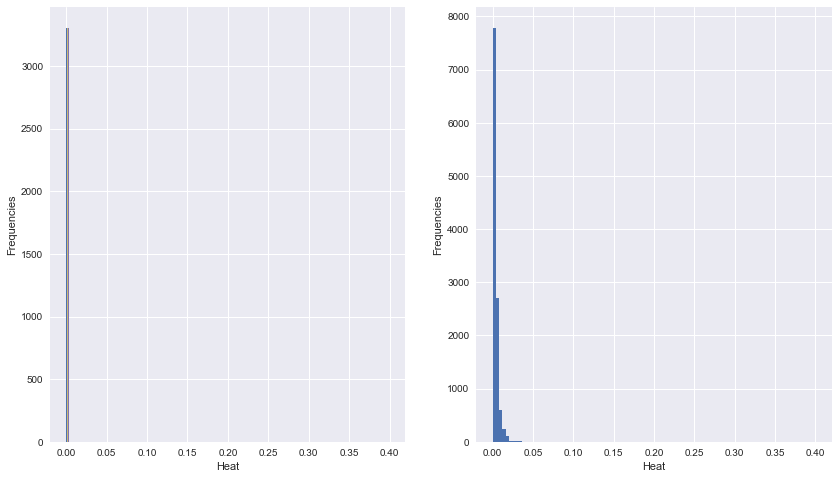

In [14]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(0, .4, 100)
plt.subplot(1, 2, 1)
x = plt.hist(features, bins=bins)
plt.xlabel('Heat')
plt.ylabel('Frequencies')
plt.subplot(1, 2, 2)
x = plt.hist(heat.heat, bins=bins)
plt.xlabel('Heat')
plt.ylabel('Frequencies')

In [15]:
import tensorflow as tf
from gcn.utils import *
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse import coo_matrix
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
checkpoint_path = os.path.join(model_dir, "model.ckpt")
#print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=True)

def str_to_num(s):
    try:
        return int(s)
    except ValueError:
        return float(s)

def load_hyper_params(model_dir):
    file_name = os.path.join(model_dir, 'hyper_params.txt')
    with open(file_name, 'r') as f:
        args = {}
        for line in f.readlines():
            key, value = line.split('\t')
            args[key.strip()] = str_to_num(value.strip())
    print ("Hyper-Parameters read from {}".format(file_name))
    return args

args = load_hyper_params(model_dir)

tf.reset_default_graph()
adj = csr_matrix(network)
F = lil_matrix(features)
F = preprocess_features(F)

poly_support = args['support']
if poly_support > 1:
    support = chebyshev_polynomials(adj, poly_support)
    num_supports = 1 + poly_support
else:
    support = [preprocess_adj(adj)]
    num_supports = 1

placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32,
                                      shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

ckpt = tf.train.get_checkpoint_state(checkpoint_dir=model_dir)
ckpt.model_checkpoint_path

if ckpt and ckpt.model_checkpoint_path:
    with tf.Session() as sess:
        model = MYGCN(placeholders,
                      input_dim=features.shape[1],
                      learning_rate=args['lr'],
                      num_hidden1=args['hidden1'],
                      num_hidden2=args['hidden2'],
                      pos_loss_multiplier=args['loss_mul'],
                      weight_decay=args['decay'],
                      logging=True)
        model.load(checkpoint_path, sess)

        feed_dict = construct_feed_dict(features=F,
                                        support=support,
                                        labels=y_train,
                                        labels_mask=train_mask,
                                        placeholders=placeholders
                                       )
        input_vals = model.activations[0]
        inp = sess.run(input_vals, feed_dict=feed_dict)


input_sp = coo_matrix((inp.values, (inp.indices[:, 0], inp.indices[:, 1])),
                        shape=inp.dense_shape)
input_np = np.array(input_sp.todense())
pd.get_dummies(input_np.squeeze()).head()

Hyper-Parameters read from ../data/GCN/training/2018_02_14_12_12_53/hyper_params.txt


/home/sasse/.local/lib/python3.6/site-packages/gcn-1.0-py3.6.egg/gcn/utils.py:97: RuntimeWarning: divide by zero encountered in power


Calculating Chebyshev polynomials up to order 2...
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_02_14_12_12_53/model.ckpt


Exception: Data must be 1-dimensional

In [ ]:
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(0, .4, 100)
plt.subplot(1, 3, 1)
x = plt.hist(features, bins=bins)
plt.xlabel('Heat')
plt.ylabel('Frequencies')
plt.title('Input Features from HDF5')
plt.subplot(1, 3, 2)
x = plt.hist(pred_with_feat.heat, bins=bins)
plt.xlabel('Heat')
plt.title('Heat Scores from Hotnet2 (0 for unknown)')
plt.subplot(1, 3, 3)
x = plt.hist(input_np)
plt.xlabel('Heat')
plt.title('Activation of input from Model')

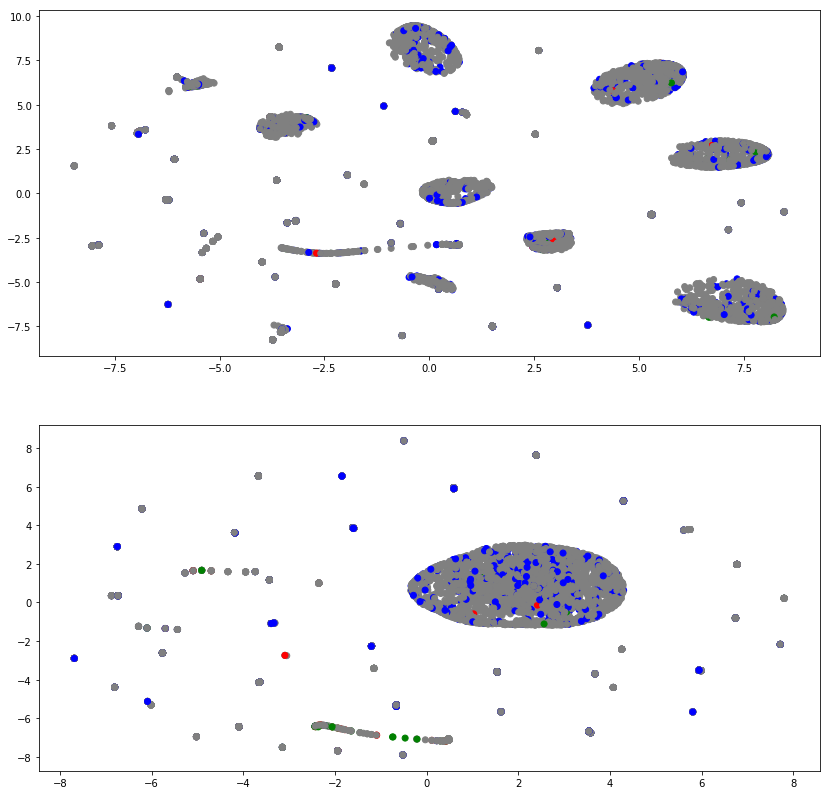

In [24]:
# build colors for TSNE plot
heat_with_labels = labels_with_pred.join(heat)
heat_with_labels.fillna(0, inplace=True)
heat_with_labels['color'] = 'grey'
heat_with_labels
heat_with_labels.loc[heat_with_labels.train_pos == 1, 'color'] = 'green'
heat_with_labels.loc[heat_with_labels.test_pos == 1, 'color'] = 'red'
heat_with_labels.loc[heat_with_labels.negative == 1, 'color'] = 'blue'

# calculate TSNE embedding for heat and features and plot it
emb = TSNE(n_components=2).fit_transform(heat)
emb2 = TSNE(n_components=2).fit_transform(features)
emb3 = TSNE(n_components=2).fit_transform(activation)
fig = plt.figure(figsize=(14, 14))
plt.subplot(2, 1, 1)
plt.scatter(emb[:, 0], emb[:, 1], c=heat_with_labels.color)
plt.subplot(2, 1, 2)
plt.scatter(emb2[:, 0], emb2[:, 1], c=heat_with_labels.color)